## БИНАРНАЯ КЛАССИФИКАЦИЯ

In [1]:
!kaggle config view

Configuration values from /home/username/.kaggle
- username: valeriyboyko
- path: None
- proxy: None
- competition: None


In [2]:
!kaggle datasets download -d joshmcadams/oranges-vs-grapefruit

Dataset URL: https://www.kaggle.com/datasets/joshmcadams/oranges-vs-grapefruit
License(s): CC0-1.0
  0%|                                               | 0.00/61.2k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 61.2k/61.2k [00:00<00:00, 532MB/s]


In [4]:
import warnings 
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd 
df = pd.read_csv("citrus.csv")
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [7]:
df.isna().mean()

name        0.0
diameter    0.0
weight      0.0
red         0.0
green       0.0
blue        0.0
dtype: float64

In [8]:
df.name.value_counts()

name
orange        5000
grapefruit    5000
Name: count, dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
df.name = enc.fit_transform(df.name)
df.head()

,name,diameter,weight,red,green,blue
0,1,2.96,86.76,172,85,2
1,1,3.91,88.05,166,78,3
2,1,4.42,95.17,156,81,2
3,1,4.47,95.60,163,81,4
4,1,4.48,95.76,161,72,9


In [22]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(df.drop('name',axis=1),df.name,test_size=.3, random_state=228)

In [46]:
print("y_train уникальные значения:", np.unique(y_train))
print("y_train тип:", type(y_train))
print("y_train примеры:", y_train[:10])

y_train уникальные значения: [0 1]
y_train тип: <class 'pandas.core.series.Series'>
y_train примеры: 4573    1
8121    0
2945    1
1613    1
642     1
4363    1
1767    1
3564    1
394     1
6504    0
Name: name, dtype: int64


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train.shape, X_test.shape, X_train_scaled.shape, X_test_scaled.shape

((7000, 5), (3000, 5), (7000, 5), (3000, 5))

In [24]:
from sklearn.metrics import (
    accuracy_score, # доля правильных ответов
    precision_score, # точность
    recall_score, # полнота
    confusion_matrix, # TN, TP, FN, FP -- для подсчёта TNR, точности и полноты для бинарной классификации
    multilabel_confusion_matrix, # возвращает список confusion_matrix (для многоклассового случая -- будет использоваться далее)
    f1_score, # F1-мера
    roc_auc_score, # ROC AUC
    roc_curve, # возвращает FPR, TPR и пороговые значения, которые использовались при подсчёте FPR и TPR
    average_precision_score, # PR AUC
    precision_recall_curve # возвращает точность, полноту и пороговые значения, которые использовались при подсчёте точности и полноты
)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [26]:
def calculate_percision_recall_f1(tn,fp,fn,tp):
    precision = tp / (tp+fp)
    recall = tp / (tp + fn)
    f1 = 2 / (precision + recall) * precision * recall

    return precision, recall, f1

In [37]:
import numpy as np

def calculate_specificity(true_labels, predictions):
    """Вычисление специфичности для бинарной и многоклассовой классификации.

    :param true_labels: истинные метки классов
    :param predictions: предсказанные метки классов
    :return: специфичность и confusion_matrix
    """
    if len(np.unique(true_labels)) < 3:
        conf_matrix = confusion_matrix(true_labels, predictions)
        tn, fp, fn, tp = conf_matrix.ravel()
        return tn / (tn + fp), (tn, fp, fn, tp)
    else:
        # в многоклассовом случае будем использовать только макро-аггрегацию
        conf_matrix = multilabel_confusion_matrix(true_labels, predictions)
        specificity = []

        for cm in conf_matrix:
            tn, fp, fn, tp = cm.ravel()
            specificity.append(tn / (tn + fp))
        return np.array(specificity).mean(), conf_matrix

In [41]:
def get_all_metrics(
    true_labels,
    predictions,
    probabilities,
    print_metrics=False,
    **kwargs,
):
    """Подсчёт и вывод всех метрик.

    :param true_labels: истинные метки классов
    :param predictions: предсказания (метки классов)
    :param probabilities: предсказания (вероятности принадлежности каждого объекта к каждому классу)
    :param print_metrics: если True, то печатает получившиеся метрики
    :return: словарь, ключи которого -- названия метрик, значения -- получившиеся метрики
    """
    kwargs_precision_recall_f1_pr_auc = dict() # для бинарной классификации никакие дополнительные параметры не нужны
    kwargs_roc_auc = dict()

    # если бинарная классификация, то используем только вероятности принадлежности к классу 1
    if len(np.unique(true_labels)) < 3:
        probabilities = probabilities[:, 1]
        true_predicted_labels_precision_recall_f1 = {
            "y_true": true_labels,
            "y_pred": predictions,
        }
        true_predicted_labels_pr_auc = {
            "y_true": true_labels,
            "y_score": probabilities,
        }
    # если многоклассовая классификация, то устанавливаем дополнительные параметры для посчета метрик
    else:
        kwargs_precision_recall_f1_pr_auc = {
            "average": kwargs["average"],
        }
        kwargs_roc_auc = {
            "multi_class": kwargs["multi_class"]
        }
        true_labels_binarize = label_binarize(true_labels, classes=np.unique(true_labels))
        predictions_binarize = label_binarize(predictions, classes=np.unique(predictions))
        true_predicted_labels_precision_recall_f1 = {
            "y_true": true_labels_binarize,
            "y_pred": predictions_binarize,
        }
        true_predicted_labels_pr_auc = {
            "y_true": true_labels_binarize,
            "y_score": probabilities,
        }
    accuracy = accuracy_score(true_labels, predictions)

    precision = precision_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc)
    recall = recall_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc)
    f1 = f1_score(**true_predicted_labels_precision_recall_f1, **kwargs_precision_recall_f1_pr_auc)

    roc_auc = roc_auc_score(true_labels, probabilities, **kwargs_roc_auc)
    pr_auc = average_precision_score(**true_predicted_labels_pr_auc, **kwargs_precision_recall_f1_pr_auc)

    specificity, conf_matrix = calculate_specificity(true_labels, predictions)

    if len(np.unique(true_labels)) < 3:
        # Для бинарной классификации просто выводим метрики
        if print_metrics:
            print(
                "Accuracy = {}\nPrecision = {}\nRecall = {}\nF1_score = {}\nROC AUC = {}\nPR AUC = {}\nSpecificity = {}".format(
                    accuracy, precision, recall, f1, roc_auc, pr_auc, specificity
                )
            )

    else:
        if print_metrics:
            print(
                "Accuracy = {}\nPrecision = {}\nRecall = {}\nF1_score = {}\nROC AUC = {}\nPR AUC = {}\nSpecificity = {}".format(
                    accuracy, precision, recall, f1, roc_auc, pr_auc, specificity
                )
            )
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
	Accuracy 	Precision 	Recall 	F1_score 	ROC AUC 	PR AUC 	Specificity
Logistic Regression 	0.937000 	0.940857 	0.931359 	0.936084 	0.984235 	0.985437 	0.942536
Decision Tree 	0.925333 	0.929252 	0.919246 	0.924222 	0.925277 	0.894211 	0.931308
kNN 	0.914333 	0.914922 	0.911844 	0.913381 	0.965976 	0.953901 	0.916777
SVM 	0.931667 	0.936605 	0.924630 	0.930579 	0.977050 	0.978551 	0.938573
        "F1_score": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Specificity": specificity
    }

In [42]:
from sklearn.preprocessing import label_binarize

def model_train_test(X_train,X_test,y_train,y_test, model, **kwargs):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)

    print(str(model), end='\n\n')

    all_metrics = get_all_metrics(
        y_test,pred,proba,print_metrics=True,**kwargs)
    return pred, proba, all_metrics

In [43]:
pred_logreg, proba_logreg, all_metrics_logreg = model_train_test(
    X_train_scaled, X_test_scaled, 
    y_train.values.ravel(),  # ← преобразуем в 1D массив
    y_test.values.ravel(),   # ← и здесь тоже
    LogisticRegression()
)

LogisticRegression()

Accuracy = 0.937
Precision = 0.9408565601631543
Recall = 0.9313593539703903
F1_score = 0.9360838687859316
ROC AUC = 0.9842350711439751
PR AUC = 0.9854370794171935
Specificity = 0.9425363276089829


In [47]:
print("=== ДИАГНОСТИКА ===")
print("Форма X_train:", X_train.shape)
print("Форма y_train:", y_train.shape)
print("Тип y_train:", type(y_train))
print("Уникальные значения в y_train:", np.unique(y_train))
print("Примеры y_train:", y_train[:5])

# Проверяем, целые ли числа (метки классов) или дробные (регрессия)
if any(isinstance(x, (int, np.integer)) for x in y_train[:10]):
    print("✅ Похоже на классификацию - целые числа")
else:
    print("❌ Похоже на регрессию - дробные числа")

=== ДИАГНОСТИКА ===
Форма X_train: (7000, 5)
Форма y_train: (7000,)
Тип y_train: <class 'pandas.core.series.Series'>
Уникальные значения в y_train: [0 1]
Примеры y_train: 4573    1
8121    0
2945    1
1613    1
642     1
Name: name, dtype: int64
✅ Похоже на классификацию - целые числа


In [48]:
pred_dt, proba_dt, all_metrics_dt = model_train_test(
    X_train_scaled,X_test_scaled, y_train.values.ravel(),y_test.values.ravel(),
    DecisionTreeClassifier()
)

DecisionTreeClassifier()

Accuracy = 0.926
Precision = 0.9316939890710383
Recall = 0.917900403768506
F1_score = 0.9247457627118644
ROC AUC = 0.9259251028089559
PR AUC = 0.8958689554236628
Specificity = 0.9339498018494056


In [49]:
pred_dt, proba_dt, all_metrics_dt = model_train_test(
    X_train,X_test, y_train.values.ravel(),y_test.values.ravel(),
    DecisionTreeClassifier()
)

DecisionTreeClassifier()

Accuracy = 0.9373333333333334
Precision = 0.9408967391304348
Recall = 0.9320323014804845
F1_score = 0.9364435429344151
ROC AUC = 0.9372843145447337
PR AUC = 0.9106128198938889
Specificity = 0.9425363276089829


In [52]:
pred_knn, proba_knn, all_metrics_knn = model_train_test(
    X_train_scaled, X_test_scaled, y_train.values,
    y_test.values,
    KNeighborsClassifier()
)

KNeighborsClassifier()

Accuracy = 0.9143333333333333
Precision = 0.9149223497636731
Recall = 0.9118438761776582
F1_score = 0.9133805190428042
ROC AUC = 0.9659757027723304
PR AUC = 0.9539006078168468
Specificity = 0.916776750330251


In [53]:
pred_svm, proba_svm, all_metrics_svm = model_train_test(
    X_train_scaled,X_test_scaled, y_train.values.ravel(),
    y_test.values.ravel(),
    SVC(probability=True)
)

SVC(probability=True)

Accuracy = 0.9316666666666666
Precision = 0.9366053169734151
Recall = 0.9246298788694481
F1_score = 0.9305790721300372
ROC AUC = 0.9770495563169058
PR AUC = 0.9785510221705993
Specificity = 0.9385733157199472


In [54]:
import matplotlib.pyplot as plt

def plot_roc_pr_curves(true_labels, algorithms):
    """Отрисовка ROC- и PR-кривых.

    :param true_labels: истинные метки классов
    :param algorithms: словарь формата {название_алгоритма: вероятности_принадлежности_к_каждому_классу}
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].set_title("ROC-curve", fontsize=20)
    ax[1].set_title("PR-curve", fontsize=20)

    for alg_name, probabilities in algorithms.items():
        fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
        precisions, recalls, _ = precision_recall_curve(true_labels, probabilities[:, 1])

        ax[0].plot(
            fpr,
            tpr,
            label="{} (ROC AUC = {})".format(
                alg_name,
                round(
                    roc_auc_score(true_labels, probabilities[:, 1]),
                    3
                )
            )
        )
        ax[1].plot(
            recalls,
            precisions,
            label="{} (PR AUC = {})".format(
                alg_name,
                round(
                    average_precision_score(true_labels, probabilities[:, 1]),
                    3
                )
            )
        )

    ax[0].legend(fontsize=14)
    ax[0].set_xlabel("False positive rate", fontsize=16)
    ax[0].set_ylabel("True positive rate", fontsize=16)

    ax[1].legend(fontsize=14)
    ax[1].set_xlabel("Recall", fontsize=16)
    ax[1].set_ylabel("Precision", fontsize=16)
    plt.show()

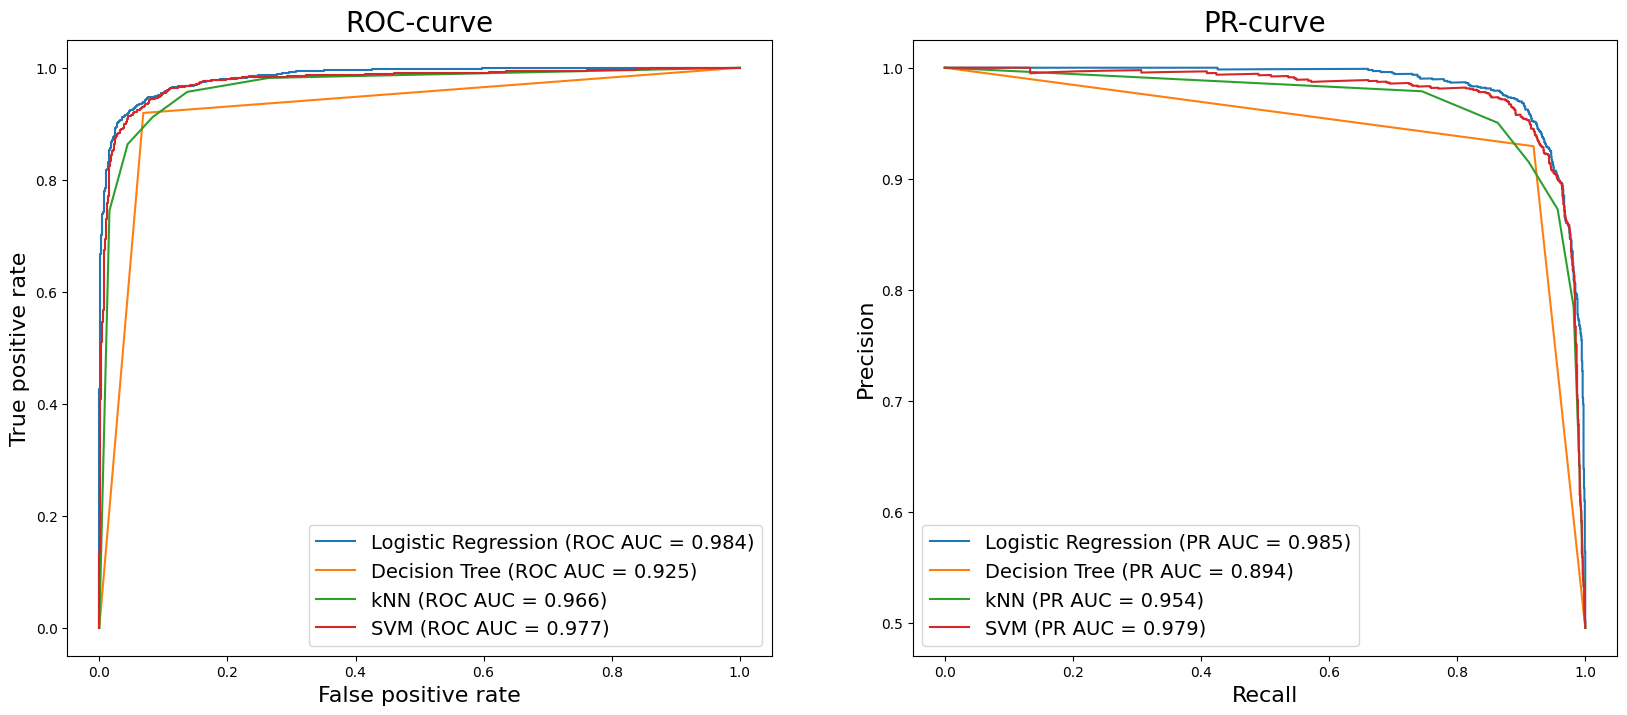

In [55]:
plot_roc_pr_curves(
    y_test,
    {
        "Logistic Regression": proba_logreg,
        "Decision Tree": proba_dt,
        "kNN": proba_knn,
        "SVM": proba_svm,
    }
)

In [56]:
ans_df = pd.DataFrame(
    [all_metrics_logreg, all_metrics_dt, all_metrics_knn, all_metrics_svm],
    index=["Logistic Regression", "Decision Tree", "kNN", "SVM"]
)
ans_df

,Accuracy,Precision,Recall,F1_score,ROC AUC,PR AUC,Specificity
Logistic Regression,0.937000,0.940857,0.931359,0.936084,0.984235,0.985437,0.942536
Decision Tree,0.925333,0.929252,0.919246,0.924222,0.925277,0.894211,0.931308
kNN,0.914333,0.914922,0.911844,0.913381,0.965976,0.953901,0.916777
SVM,0.931667,0.936605,0.924630,0.930579,0.977050,0.978551,0.938573


In [57]:
for metric in ans_df.columns:
    sorted_ans_df = ans_df.sort_values(by=metric, ascending=False)
    print(
        "{}:{}{}".format(
            metric,
            " " * (20 - len(metric)),
            sorted_ans_df.index.tolist()
        )
    )

Accuracy:            ['Logistic Regression', 'SVM', 'Decision Tree', 'kNN']
Precision:           ['Logistic Regression', 'SVM', 'Decision Tree', 'kNN']
Recall:              ['Logistic Regression', 'SVM', 'Decision Tree', 'kNN']
F1_score:            ['Logistic Regression', 'SVM', 'Decision Tree', 'kNN']
ROC AUC:             ['Logistic Regression', 'SVM', 'kNN', 'Decision Tree']
PR AUC:              ['Logistic Regression', 'SVM', 'kNN', 'Decision Tree']
Specificity:         ['Logistic Regression', 'SVM', 'Decision Tree', 'kNN']


## МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ

In [65]:
from sklearn.datasets import load_wine

wine_data = load_wine()
wine_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [68]:
df = pd.DataFrame(wine_data['data'], columns=wine_data['feature_names'])
target = wine_data['target']
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [75]:
pd.Series(target).value_counts()

1    71
0    59
2    48
Name: count, dtype: int64

In [76]:
X_train,X_test,y_train,y_test = train_test_split(df, target, train_size=.33, random_state = 228)

In [78]:
def all_average_multi_class_combinations(X_train,y_train,X_test,y_test,model,verbose=0):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)

    if verbose > 0:
        print(str(model),end='\n\n')

    ans = dict()
    ans['ROC AUC'] = dict()
    metrics_to_compare = ['Precision','Recall','F1_score','PR AUC']
    for m in metrics_to_compare:
        ans[m] = dict()

    for average in ['macro','micro','weighted']:
        for multi_class in ["ovr",'ovo']:
            if verbose > 0:
                print('\n{}_{}'.format(average, multi_class))

            all_metrics = get_all_metrics(
                y_test,pred,proba,calc_specificity = False, print_metrics = verbose > 0, average = average, 
                multi_class = multi_class
            )

            for m in metrics_to_compare:
                ans[m][average] = all_metrics[m]
            ans['ROC AUC'][multi_class] = all_metrics['ROC AUC']
    if verbose > 0:
        print('-'*100, end='\n\n')
    for k,v in ans.items():
        print(k,'\n',v)
    return ans

In [79]:
dt = all_average_multi_class_combinations(X_train,y_train,X_test,y_test, DecisionTreeClassifier(),verbose=1)

DecisionTreeClassifier()


macro_ovr
Accuracy = 0.8333333333333334
Precision = 0.8296961916987592
Recall = 0.8469582704876822
F1_score = 0.8313512361466326
ROC AUC = 0.8833646245979295
PR AUC = 0.7568399625410877
Specificity = 0.9197709787081768

macro_ovo
Accuracy = 0.8333333333333334
Precision = 0.8296961916987592
Recall = 0.8469582704876822
F1_score = 0.8313512361466326
ROC AUC = 0.8852187028657618
PR AUC = 0.7568399625410877
Specificity = 0.9197709787081768

micro_ovr
Accuracy = 0.8333333333333334
Precision = 0.8333333333333334
Recall = 0.8333333333333334
F1_score = 0.8333333333333334
ROC AUC = 0.8833646245979295
PR AUC = 0.7500000000000001
Specificity = 0.9197709787081768

micro_ovo
Accuracy = 0.8333333333333334
Precision = 0.8333333333333334
Recall = 0.8333333333333334
F1_score = 0.8333333333333334
ROC AUC = 0.8852187028657618
PR AUC = 0.7500000000000001
Specificity = 0.9197709787081768

weighted_ovr
Accuracy = 0.8333333333333334
Precision = 0.8478818998716303
Recall = 0.83333333

In [81]:
from sklearn.ensemble import RandomForestClassifier

rf = all_average_multi_class_combinations(X_train,y_train,X_test,y_test, RandomForestClassifier(),verbose=1)

RandomForestClassifier()


macro_ovr
Accuracy = 0.9333333333333333
Precision = 0.9281842818428184
Recall = 0.9477124183006537
F1_score = 0.9329948420373952
ROC AUC = 0.9996211044804394
PR AUC = 0.9994944856719354
Specificity = 0.9695473251028807

macro_ovo
Accuracy = 0.9333333333333333
Precision = 0.9281842818428184
Recall = 0.9477124183006537
F1_score = 0.9329948420373952
ROC AUC = 0.999664823194235
PR AUC = 0.9994944856719354
Specificity = 0.9695473251028807

micro_ovr
Accuracy = 0.9333333333333333
Precision = 0.9333333333333333
Recall = 0.9333333333333333
F1_score = 0.9333333333333333
ROC AUC = 0.9996211044804394
PR AUC = 0.991913193627245
Specificity = 0.9695473251028807

micro_ovo
Accuracy = 0.9333333333333333
Precision = 0.9333333333333333
Recall = 0.9333333333333333
F1_score = 0.9333333333333333
ROC AUC = 0.999664823194235
PR AUC = 0.991913193627245
Specificity = 0.9695473251028807

weighted_ovr
Accuracy = 0.9333333333333333
Precision = 0.942479674796748
Recall = 0.9333333333333

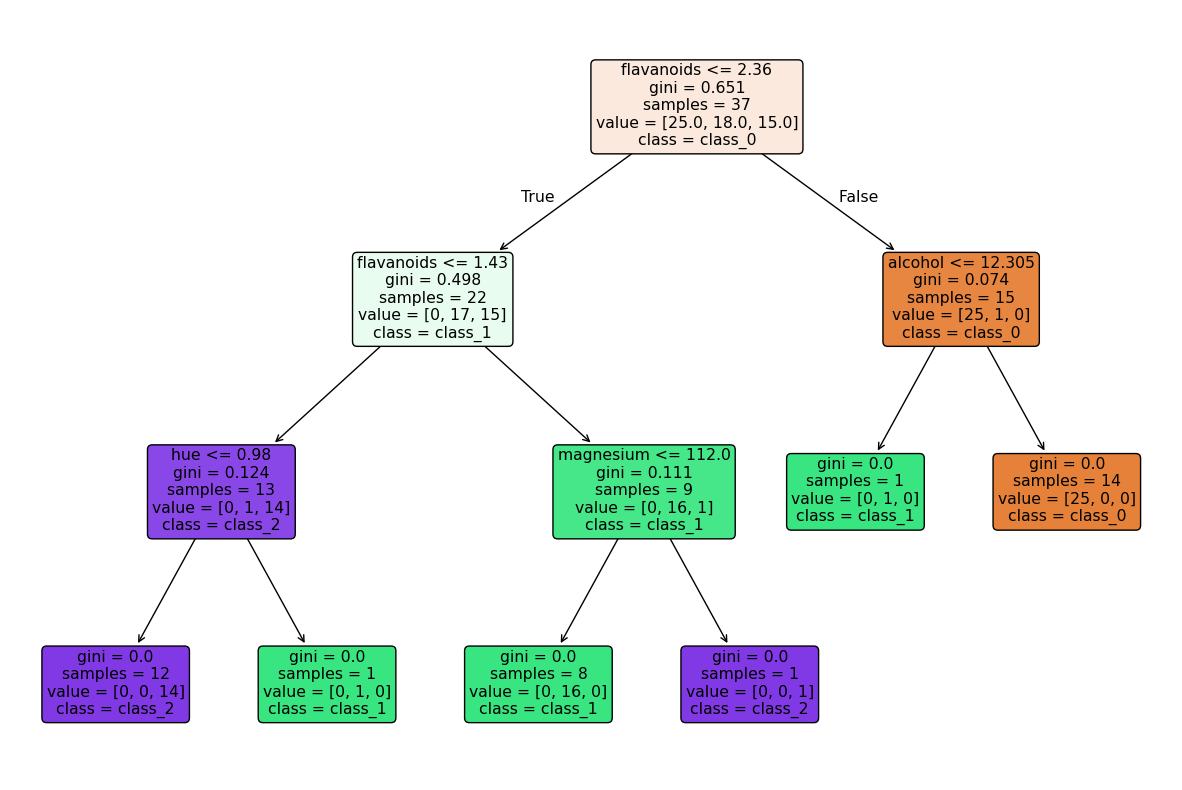

In [83]:
from sklearn.tree import plot_tree

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

fig = plt.figure(figsize=(15, 10))
plot_tree(
    rf_clf.estimators_[0], # визуализация дерева с индексом 0; всего len(rf_clf.estimators_) деревьев
    feature_names=wine_data.feature_names,
    class_names=wine_data.target_names,
    filled=True,
    impurity=True,
    rounded=True
);